# Modelos discretos de Depredador-Presa

In [1]:
using PyPlot, LaTeXStrings, TaylorSeries

include("AutomDiff_V2.jl")
import AD: Dual, xdual

Los Modelos de Cazador-Presa son aquellos que representan la interacción de dos especies, una como cazador y otra como presa utilziados principalmente en ecología y biología pero con un sinúmero de aplicaciones en otras áreas de física, química y hasta economía.

En ecología se llaman modelos de "Depredador—presa" o de "planta—hervíboro". En este trabajo se les llama, modelos de "Depredador-Presa".

## Un modelo simple

Siguiendo la línea del libro de  [_Allman & Rhodes_](http://bookzz.org/book/436360/381bdc "Allman, Elizabeth S.; Rhodes, John A. 2003. Mathematical models in biology. An introduction") usaremos un modelo simple en este trabajo:

Si se tienen dos especies, una de la cual es presa de la otra. También asumimos que la interacción entre las dos especies es el factor primario para determinar el tamaño de la población.

Denotamos $P_t$ el tamaño de la población de presas y $Q_t$ el tamaño de la población de de depredadores en un tiempo $t$, el cambio en la población de las dos especies está interrelacionado:

$$
\begin{aligned}
\Delta P &= F(P,Q)\\
\Delta Q &= G(P,Q)
\end{aligned}
$$

Ahora, para definir las funciones $F$ y $G$ de cambio pensemos en el caso en que no hubises predadores, la población de presas crecería hasta un punto en el que no hubiese más lugar o recursos, por lo que se emplea un crecimiento logístico, la forma discreta se escribe como:

$$
\Delta P = rP\left( 1-\frac{P}{K} \right)
$$

Si las presas son la principal fuente de comida de los depredadores, entonces la población de depredadores es directamente proporcional a la de presas:

$$
\Delta Q = -u Q
$$

Con $u$ una constante positiva.

Para introducir la interacción mutua entre las dos especies empleamos el producto $PQ$. Por lo que el modelo resulta como:

$$
\begin{aligned}
\Delta P &= rP\left( 1-\frac{P}{K} \right)-sPQ\\
\Delta Q &= -uQ+vPQ
\end{aligned}
$$

Donde $s$ y $v$ son constantes positivas que denontan que tanto afecta o beneficia la interacción entre ambas especies a las presas o a los depredadores, respectivamente.

Si escribimos el modelo en términos de la población en lugar de cambios en la población obtenemos:

 ##### Modelo simple
$$
\begin{aligned}
P_{t+1} &= P_t \left( 1+r \left( 1-\frac{P_t}{K} \right)\right)-s P_t Q_t\\
Q_{t+1} &= (1-u)Q_t+v P_t Q_t
\end{aligned}
$$

Con $r$, $s$, $u$, $v$ y $K$ constantes positivas, y $u<1$.


Observamos que el módelo es un mapeo discreto de varias componentes y múltiples constantes. Definamos la función que define el mapeo:

In [2]:
"""
    CP_Simple(Xt,constantes)

Dado un vector con los valores de la población de presas y depredadores 
Xt=[P,Q], realiza el siguiente paso con el modelo simple.

"""
function CP_Simple(Xt::Vector{Float64},constantes::Vector{Float64})
    
    @assert length(Xt)==2 && length(constantes) == 5
    
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    K = constantes[5]
    
    #Asignación del paso 0
    P0 = Xt[1]
    Q0 = Xt[2]
    #Evaluación del modelo
    P1 = P0*(1+r*(1-P0/K))-s*P0*Q0
    Q1 = (1-u)*Q0+v*P0*Q0
    
    #Resultados
    [P1,Q1]   
end

CP_Simple

In [3]:
"""
    mapeo2D_lista(F,X_0,constantes,t)
Dada una función `F(X_0,constantes)` que define un mapeo de 2 dimensiones
un punto inicial `X_0` y las `constantes` en forma de vector, regresa dos
vectores con los `t` iterados del mapeo para cada dimensión.

"""

function mapeo2D_lista(F::Function , X_0::Vector{Float64},constantes,t::Int64)
    @assert length(X_0)==2 && t > 0
    
    X0 = X_0
    #Definición de los vectores para almacenar resultados.
    Ps = [X0[1]]
    Qs = [X0[2]]
    
    for i in 1:t-1
        X0 = F(X0,constantes)
        push!(Ps,X0[1])
        push!(Qs,X0[2])
    end
    Ps,Qs
end

mapeo_PQ_ts(v_0,r,s,u,v,t) = mapeo_PQ_ts(v_0,r,s,u,v,1.0,t)

mapeo_PQ_ts (generic function with 1 method)

Veamos un ejemplo con parámetros específicos:

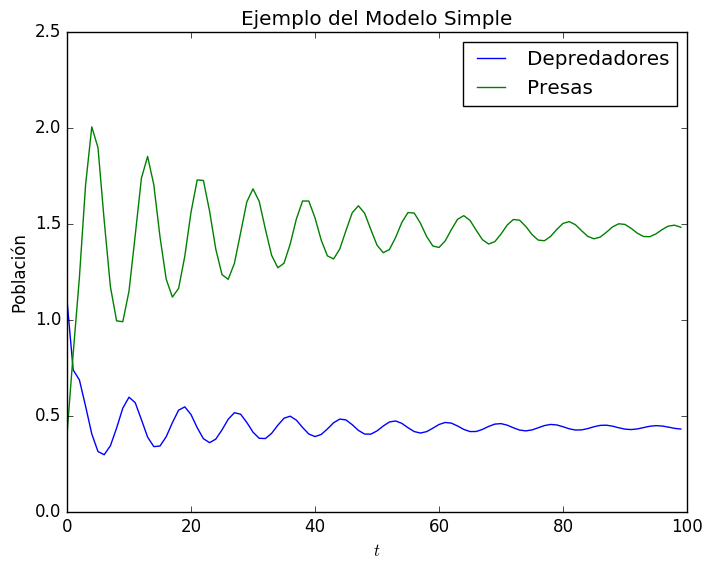

PyObject <matplotlib.text.Text object at 0x000000001E8CAF60>

In [4]:
r,s,u,v,K = 1.3,.5,.7,1.6,1.
const1 = [r,s,u,v,K]
X0 = [1.10,0.40]

Ps1,Qs1 = mapeo2D_lista(CP_Simple,X0,const1,100)

plot(Ps1,label="Depredadores")
plot(Qs1,label="Presas")
xlabel(L"t")
ylabel("Población")
legend()
title("Ejemplo del Modelo Simple")

El gráfico muestra las características clásicas de estos modelos, poblaciones que oscilan alrededor de un punto de queilibrio, esto es más notorio si se grafica el diagrama de fase:

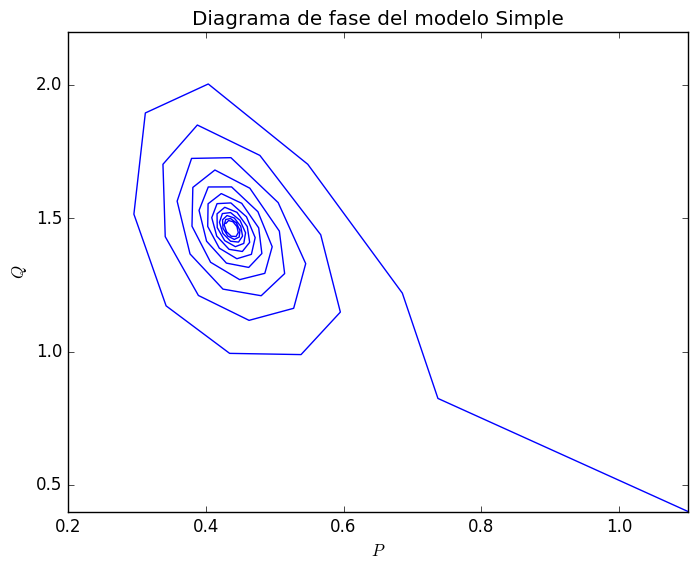

  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31


PyObject <matplotlib.text.Text object at 0x000000001EA37C50>

In [5]:
plot(Ps1,Qs1)
xlabel(L"P")
ylabel(L"Q")
title("Diagrama de fase del modelo Simple")

Sin embargo, no se trabajará con el mapeo simple definido anteriormente, en su lugar trabajaremos con un modelo de depredador-presa que no considera los individuos de la generación anterior y simplemente toma el cambio poblacional en cada iterado, quitando esos términos del modelo simple. Además, Sin perder generalidad, podemos hacer $K=1$, que de todas formas puede ser absorbida por un cambio de unidades de $P$ de la forma $P'=P/K$ y absorviendo la $K$ en las constantes:

#####  Modelo sólo cambio poblacional

$$
\begin{aligned}
P_{t+1} &= r P_t \left( 1-P_t \right)-s P_t Q_t\\
Q_{t+1} &= -uQ_t+v P_t Q_t
\end{aligned}
$$



In [6]:
function CP_cambio(Xt::Vector{Float64},constantes::Vector{Float64})
    
    @assert length(Xt)==2 && length(constantes) == 4
    
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    
    #Asignación del paso 0
    P0 = Xt[1]
    Q0 = Xt[2]
    #Evaluación del modelo
    P1 = r*P0*(1-P0)-s*P0*Q0
    Q1 = -u*Q0+v*P0*Q0
    
    #Resultados
    [P1,Q1]   
end

  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31

CP_cambio (generic function with 1 method)

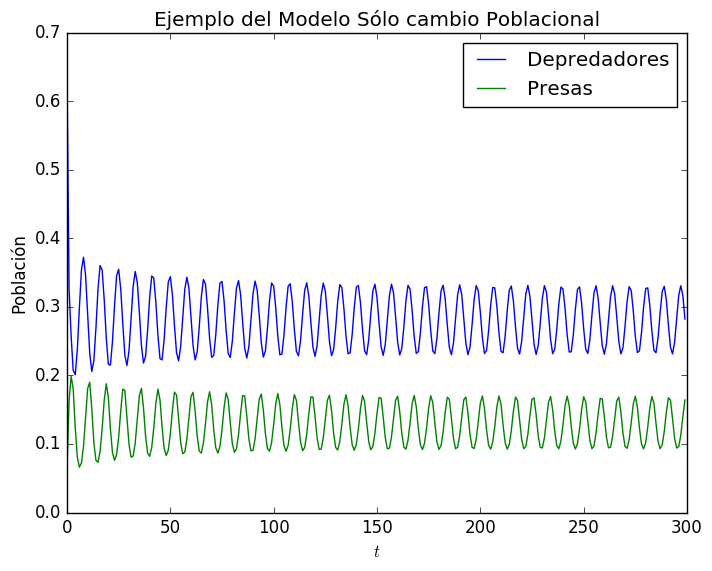

PyObject <matplotlib.text.Text object at 0x00000000026CDF60>

In [28]:
r,s,u,v = 2.02,3.5,0.25,4.5

const2 = [r,s,u,v]
X0 = [0.641,0.062]

Ps2,Qs2 = mapeo2D_lista(CP_cambio,X0,const2,300)

plot(Ps2,label="Depredadores")
plot(Qs2,label="Presas")
xlabel(L"t")
ylabel("Población")
legend()
title("Ejemplo del Modelo Sólo cambio Poblacional")

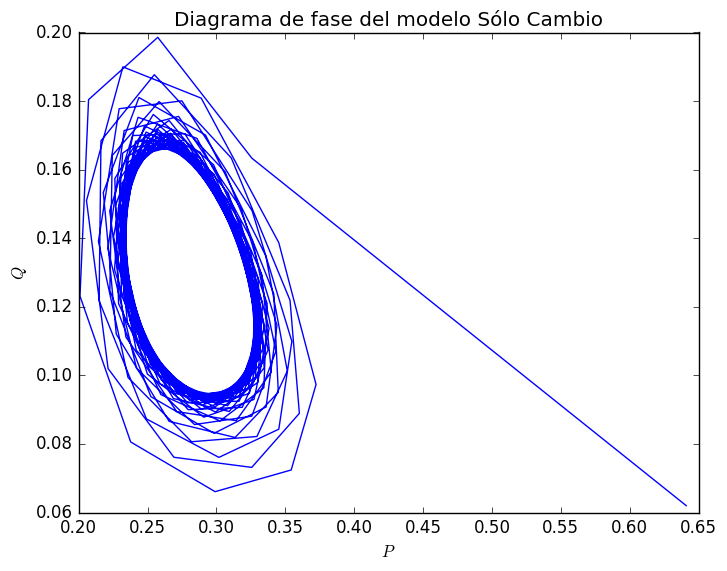

PyObject <matplotlib.text.Text object at 0x0000000022099748>

In [30]:
plot(Ps2,Qs2)
xlabel(L"P")
ylabel(L"Q")
title("Diagrama de fase del modelo Sólo Cambio")

Observamos que la dinámica de este modelo se parece mucho al modelo simple, pero con algunas características peculiares, como la bifurcación que se ve en el último gráfico.

## Puntos fijos


Buscamos $(P,Q)$ tal que 

$$
\begin{aligned}
P &= rP \left( 1-P \right)-s P Q\\
Q &= -uQ+v P Q
\end{aligned}
$$

Los puntos fijos son:


\begin{aligned}
E_0 &= [0.0 ,0.0]\\
E_1 &= [1.0 ,0.0]\\
E_2 &= \left[\frac{1+u}{v} ,\frac{r}{s}\left(1-\frac{1+u}{ v} \right) -\frac{1}{s} \right]
\end{aligned}

Como el modelo es de poblaciones, los puntos fijos para existir deben permanecer positivos. $E_0$ y $E_1$ siempre existen, para que la condición se cumpla en $E_3$ tenemos:

$$ 
r>\frac{v}{v-1-u}
$$

El jacobiano del mapeo para $E_2$:

$$
J(E_2)=
\begin{pmatrix}
1-\frac{(1+u)r}{v} & -\frac{s(1+u)}{v} \\ 
 \frac{v(r-1)-(1+u)r}{s}& 1
\end{pmatrix}
$$

La ecuación característica del Jacobiano:

$$\lambda^2+\alpha_1\lambda+\alpha_2=0$$

con $\alpha_1=-trJ=-2+\frac{(1+u)r}{v}$, $\alpha_2=detJ=(1+u)r\left(1-\frac{2+u}{v}\right)-u$:

Entonces:

$$
\lambda_{1,2}=-\frac{\alpha_{1}}{2}\pm\sqrt{\Delta}
$$

Con $\Delta = \left(\frac{\alpha_{1}}{2} \right)^2-\alpha_2=\left(1+\frac{(1+u)r}{2v} \right)^2-(1+u)r\left(1-\frac{u}{v}\right)+u$

Si $\Delta > 0$ tenemos $r>-\frac{4\left(uv-v^2\right)}{u}$

## Bifurcaciones

Para encontrar las bifuraciones debemos fijar los parámetros y variar solamente uno de los parámetros:

In [7]:
#Nuevo método de la función mapeo2D_lista, para quedarse sólo con cierto número de valores finales `tout`
function mapeo2D_lista(F::Function , X_0::Vector{Float64},constantes,tin::Int64,tout::Int64)
    
    @assert length(X_0)==2 &&  tin > 0 && tout > 0
    
    X0 = X_0
    
    for i in 1:tin
        X0 = F(X0,constantes)
    end
    
    mapeo2D_lista(F , X0, constantes,tout)

end

.
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Rodolfo\.julia\v0.5\IJulia\src\kernel.jl:31

mapeo2D_lista (generic function with 2 methods)

In [13]:
function diagbifurc2D(F::Function,rrange::Range{Float64}, tin::Int64,tout::Int64)
    
    #Definición de variables
    X = Vector{Float64}(tout)
    Y = Vector{Float64}(tout)
    
    xx = Array{Float64,2}(tout, length(rrange))
    yy = Array{Float64,2}(tout, length(rrange))
    
    X0 = [0.641,0.061]
    for ic in eachindex(rrange)
        r = rrange[ic]
        X,Y = mapeo2D_lista(F, X0,r,tin,tout)
        
        xx[:,ic] = X
        yy[:,ic] = Y
    end
    
    return xx,yy
    
end    

diagbifurc2D (generic function with 2 methods)

In [14]:
#Función para generar los valores del punto fijo E_2
function pE2(constantes)
    r = constantes[1]
    s = constantes[2]
    u = constantes[3]
    v = constantes[4]
    [(1+u)/v,(r*(1-(1+u)/v)-1)/s]
end

pE2 (generic function with 1 method)

.


In [15]:
rrange1 = 3.0:2.0^-8:4
s,u,v = 3.0,0.5,1.95
F1(Xt,r)=CP_cambio(Xt,[r,s,u,v])
p1(r)=pE2([r,s,u,v])

p1 (generic function with 1 method)

(Any, Any) in module Main at In[10]:3 overwritten at In[15]:3.


In [16]:
Ps3,Qs3=diagbifurc2D(F1, rrange1, 10000,300)

Rs3 = ones(size(Ps3)[1])*rrange1'

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
Ps3 = reshape(Ps3, size(Ps3)[1]*size(Ps3)[2]);
Qs3 = reshape(Qs3, size(Qs3)[1]*size(Qs3)[2]);
Rs3 = reshape(Rs3, size(Rs3)[1]*size(Rs3)[2]);

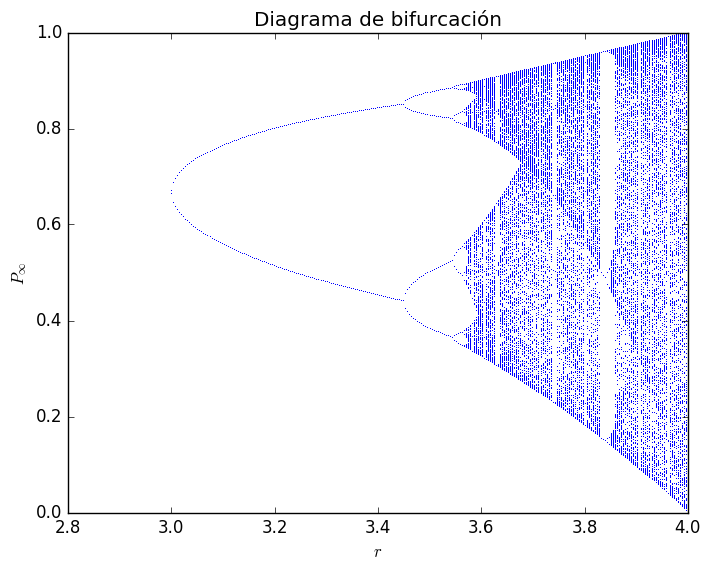

PyObject <matplotlib.text.Text object at 0x000000000181D978>

In [20]:
plot(Rs3,Ps3,"b,")
xlabel(L"r")
ylabel(L"P_{\infty}")
title("Diagrama de bifurcación")

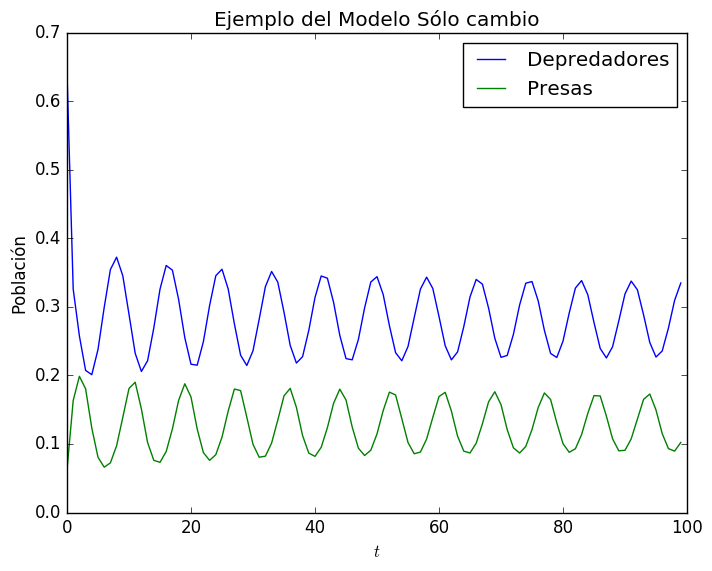

PyObject <matplotlib.text.Text object at 0x0000000001D8E908>